# League of Legends Narrative Generator
### Henry Hu, Suhho Lee, Victor Wei

## 1. Data Preprocessing

In [ ]:
import time
import json
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException
from tqdm import tqdm
import random
import re
import traceback

class LoLChampionScraper:
    def __init__(self):
        self.champions_url = "https://universe.leagueoflegends.com/en_US/champions/"
        self.base_url = "https://universe.leagueoflegends.com"
        self.champions_data = []

        self.chrome_options = Options()
        self.chrome_options.add_argument("--window-size=1920,1080")
        self.chrome_options.add_argument("--disable-gpu")
        self.chrome_options.add_argument("--no-sandbox")
        self.chrome_options.add_argument("--disable-dev-shm-usage")
        self.chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36") # Example user agent
        self.driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=self.chrome_options)
        print("WebDriver Initialized")

    def extract_champions_list(self):
        """Extract list of champions using Selenium"""
        self.driver.get(self.champions_url)
        time.sleep(5)
        selectors = [
            "li.item_30l8 a",
            ".champsListUl_2Lmb li a",
            "a[href*='/champion/']"
        ]
        champions = []
        timeout = 10
        for selector in selectors:
            try:
                WebDriverWait(self.driver, timeout).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, selector))
                )
                champion_elements = self.driver.find_elements(By.CSS_SELECTOR, selector)
                if champion_elements:
                    for element in champion_elements:
                        try:
                            url = element.get_attribute("href")
                            if not url or not url.startswith(self.base_url):
                                continue
                            name_element = element.find_element(By.CSS_SELECTOR, "h1") if element.find_elements(By.CSS_SELECTOR, "h1") else None
                            region_element = element.find_element(By.CSS_SELECTOR, "h2") if element.find_elements(By.CSS_SELECTOR, "h2") else None
                            name = name_element.text.strip() if name_element and name_element.text else ""
                            region = region_element.text.strip() if region_element and region_element.text else ""
                            if name and url and not any(c['name'] == name.upper() for c in champions):
                                champions.append({'name': name.upper(), 'region': region, 'url': url})
                        except Exception as e: print(f"  Warn: Error processing a champion list element: {e}")
                    if champions:
                        print(f"  Successfully extracted champion list using selector: {selector}")
                        break
            except TimeoutException: print(f"  Selector {selector} timed out.")
            except Exception as e: print(f"  Selector {selector} failed with error: {e}")
        print(f"Found {len(champions)} unique champions")
        return champions

    def extract_champion_details(self, champion_data):
        """Extract detailed information for a specific champion's main page"""
        print(f"Extracting details for {champion_data['name']}...")
        if not champion_data.get('url'):
            print(f"  Error: Missing URL for {champion_data['name']}")
            return champion_data
        try:
            self.driver.get(champion_data['url'])
            WebDriverWait(self.driver, 15).until(EC.presence_of_element_located((By.CSS_SELECTOR, "body")))
            time.sleep(1 + random.random())
        except Exception as e:
            print(f"  Error navigating to champion page {champion_data['url']}: {e}")
            return champion_data

        # Extract Role, Race, Quote, Short Bio
        try:
            role_element = WebDriverWait(self.driver, 5).until(EC.presence_of_element_located((By.CSS_SELECTOR, ".typeDescription_ixWu h6, .playerType_3laO h6")))
            champion_data['role'] = role_element.text.strip()
        except: champion_data['role'] = ""
        try:
            race_elements = self.driver.find_elements(By.CSS_SELECTOR, ".ChampionRace_a_Fp h6, .race_3k58 h6")
            champion_data['race'] = race_elements[0].text.strip() if race_elements else ""
        except: champion_data['race'] = ""
        try:
            quote_elements = self.driver.find_elements(By.CSS_SELECTOR, ".quote_2507 p, .championQuotes_3FLE p")
            champion_data['quote'] = quote_elements[0].text.strip() if quote_elements else ""
        except: champion_data['quote'] = ""
        
        # IMPROVED: Extract short bio with multiple selectors and approaches
        try:
            # First try the original approach
            bio_elements = self.driver.find_elements(By.CSS_SELECTOR, ".biographyText_3-to p, .biography_3YIe p")
            if bio_elements and bio_elements[0].text.strip():
                champion_data['short_bio'] = bio_elements[0].text.strip()
            else:
                # Try getting the text from the div container directly
                bio_containers = self.driver.find_elements(By.CSS_SELECTOR, ".biographyText_3-to, .biography_3YIe")
                if bio_containers:
                    container_text = bio_containers[0].text.strip()
                    if container_text:
                        # Split by newlines and take the first paragraph if multiple exist
                        paragraphs = [p.strip() for p in container_text.split('\n') if p.strip()]
                        if paragraphs:
                            champion_data['short_bio'] = paragraphs[0]
                        else:
                            champion_data['short_bio'] = container_text
                    else:
                        champion_data['short_bio'] = ""
                else:
                    champion_data['short_bio'] = ""
        except Exception as e:
            print(f"  Warn: Error extracting short bio: {e}")
            champion_data['short_bio'] = ""

        # Extract Related Champions
        related_champions = []
        try:
            h5_locator = (By.CSS_SELECTOR, "ul.champions_jmhN li.champion_1xlO h5")
            WebDriverWait(self.driver, 3).until(EC.presence_of_element_located(h5_locator))
            related_elements = self.driver.find_elements(*h5_locator)
            if related_elements:
                for i, elem in enumerate(related_elements):
                    try:
                        champion_name = self.driver.execute_script("return arguments[0].textContent;", elem).strip()
                        if champion_name and champion_name not in related_champions:
                            related_champions.append(champion_name)
                    except Exception as inner_e: 
                        print(f"    Warn: Error processing related champion element {i+1}: {type(inner_e).__name__} - {inner_e}")
        except Exception as e: 
            print(f"  Warn: An unexpected error occurred while finding/processing related champions: {type(e).__name__} - {e}")
        champion_data['related_champions'] = related_champions
        print(f"  Assigned related champions list: {champion_data['related_champions']}")

        # Find Biography URL
        try:
            bio_link_elements = self.driver.find_elements(By.XPATH, "//a[.//button[.//span[contains(text(), 'Read Biography') or contains(text(), 'Read Bio')]]]|//a[contains(@href,'/story/champion/')]")
            found_bio_url = ""
            if bio_link_elements:
                for link_el in bio_link_elements:
                    href = link_el.get_attribute('href')
                    if href and '/story/champion/' in href: found_bio_url = href; break
                if not found_bio_url: found_bio_url = bio_link_elements[0].get_attribute('href')
            if found_bio_url: champion_data['bio_url'] = found_bio_url
            else:
                clean_name = re.sub(r'[^a-z0-9]', '', champion_data['name'].lower()); bio_url = f"{self.base_url}/en_US/story/champion/{clean_name}/"; champion_data['bio_url'] = bio_url; print(f"  Warn: Could not find bio button/link, constructed fallback URL: {bio_url}")
        except Exception as e: 
            print(f"  Warn: Could not find or construct biography URL: {e}"); champion_data['bio_url'] = ""
        champion_data['story_url'] = ""
        return champion_data

    def extract_page_content(self, container_selector, paragraph_selector):
        """Helper function to extract joined paragraph text from a container."""
        full_text = ""
        paragraphs_count = 0
        try:
            print(f"  Attempting to find container '{container_selector}' directly in DOM...")
            container_elements = self.driver.find_elements(By.CSS_SELECTOR, container_selector)

            if not container_elements:
                print(f"  Error: Container '{container_selector}' not found in DOM after interaction attempt.")
                return full_text, paragraphs_count

            container_element = container_elements[0]
            print(f"  Container '{container_selector}' found in DOM.")

            paragraphs = container_element.find_elements(By.CSS_SELECTOR, paragraph_selector)
            paragraphs_count = len(paragraphs)
            if paragraphs:
                extracted_texts = []
                for i, p in enumerate(paragraphs):
                    try:
                        para_text = self.driver.execute_script(
                            "return arguments[0].textContent;", p
                        ).strip()
                        if para_text:
                            extracted_texts.append(para_text)
                    except Exception as inner_e:
                        print(f"    Warn: Error processing paragraph {i+1}: {type(inner_e).__name__} - {inner_e}")

                full_text = "\n\n".join(extracted_texts)
                if not full_text and paragraphs_count > 0:
                    print(f"  Warn: Found {paragraphs_count} paragraphs in '{container_selector}', but all textContent was empty after processing.")
            else:
                print(f"  Warn: Container '{container_selector}' found, but no paragraphs matched selector '{paragraph_selector}'.")

        except Exception as e:
            print(f"  Error: Exception finding/processing content within '{container_selector}': {type(e).__name__} - {e}")

        return full_text, paragraphs_count

    def extract_bio_and_story(self, champion_data):
        """Extract full biography from bio_url and find the story_url."""
        champion_data['full_biography'] = ""
        if not champion_data.get('bio_url'):
            print(f"  Info: No biography URL available for {champion_data['name']}")
            return champion_data

        print(f"Navigating to biography page for {champion_data['name']}...")
        try:
            self.driver.get(champion_data['bio_url'])
            WebDriverWait(self.driver, 15).until(EC.presence_of_element_located((By.CSS_SELECTOR, "body")))
            time.sleep(1 + random.random())
        except Exception as nav_e:
            print(f"  Error navigating to biography URL '{champion_data['bio_url']}': {nav_e}")
            return champion_data
        
        clicked_scroll_button = False
        try:
            button_selector = (By.CSS_SELECTOR, "p.cta_VVdh")
            scroll_button = WebDriverWait(self.driver, 7).until(
                EC.presence_of_element_located(button_selector)
            )
            print("  'Scroll to Begin' button (p.cta_VVdh) is present.")
            try:
                self.driver.execute_script("arguments[0].scrollIntoView({block: 'center', inline: 'nearest'});", scroll_button)
                time.sleep(1.0)
                self.driver.execute_script("arguments[0].click();", scroll_button)
                print("  Attempted click 'Scroll to Begin' button via JavaScript.")
                clicked_scroll_button = True
                print("  Performing small scroll down after click...")
                self.driver.execute_script("window.scrollBy(0, 150);")
                time.sleep(0.5)
            except Exception as js_click_e:
                print(f"  Warn: JavaScript click execution failed: {type(js_click_e).__name__} - {js_click_e}")
        except TimeoutException:
            print("  Info: 'Scroll to Begin' button (p.cta_VVdh) not found within timeout.")
        except Exception as scroll_e:
            print(f"  Warn: Error interacting with 'Scroll to Begin' button: {type(scroll_e).__name__} - {scroll_e}")

        primary_paragraph_selector = "p.p_1_sJ"
        container_selector = "#CatchElement"
        bio_text, para_count = self.extract_page_content(container_selector, primary_paragraph_selector)
        champion_data['full_biography'] = bio_text

        if bio_text:
            actual_paragraphs = len(bio_text.split('\n\n'))
            print(f"  Extracted biography text ({actual_paragraphs} non-empty paragraphs joined).")
        elif not bio_text:
            print(f"  Warn: Failed to extract biography text content from '{container_selector}'.")

        story_button_found = False
        try:
            story_links = self.driver.find_elements(By.XPATH, 
                "//a[.//button[.//span[contains(text(), 'story') or contains(text(), 'Story')]]]|" +
                "//a[contains(@href,'/story/')][not(contains(@href, '/story/champion/'))]|" +
                "//a[contains(@href,'-color-story')]"
            )
            
            found_story_url = ""
            if story_links:
                for link in story_links:
                    href = link.get_attribute('href')
                    if href and ('/story/' in href) and ('/story/champion/' not in href):
                        found_story_url = href
                        story_button_found = True
                        break
                
                if not found_story_url and story_links:
                    found_story_url = story_links[0].get_attribute('href')
                    story_button_found = True
            
            if found_story_url:
                champion_data['story_url'] = found_story_url
                print(f"  Found story URL on bio page: {champion_data['story_url']}")
            else:
                print(f"  No story link found on bio page.")
                champion_data['story_url'] = ""
        except Exception as e:
            print(f"  Warn: Error finding story link on bio page: {e}")
            champion_data['story_url'] = ""
            
        if not story_button_found and not champion_data['story_url']:
            try:
                clean_name = re.sub(r'[^a-z0-9]', '', champion_data['name'].lower())
                fallback_url = f"{self.base_url}/en_US/story/{clean_name}-color-story/"
                print(f"  Creating fallback story URL: {fallback_url}")
                champion_data['story_url'] = fallback_url
            except Exception as fallback_e:
                print(f"  Error creating fallback story URL: {fallback_e}")
                champion_data['story_url'] = ""
                
        return champion_data

    def extract_story_content(self, champion_data):
        """Extract the full story content from the story URL"""
        champion_data['full_story'] = ""
        if not champion_data.get('story_url') or not champion_data['story_url'].startswith(self.base_url):
            print(f"  Info: No valid story URL available for {champion_data['name']}")
            return champion_data

        print(f"Navigating to story page for {champion_data['name']}...")
        try:
            self.driver.get(champion_data['story_url'])
            WebDriverWait(self.driver, 15).until(EC.presence_of_element_located((By.CSS_SELECTOR, "body")))
            time.sleep(1 + random.random())
        except Exception as nav_e:
            print(f"  Error navigating to story URL '{champion_data['story_url']}': {nav_e}")
            return champion_data

        clicked_scroll_button = False
        try:
            button_selector = (By.CSS_SELECTOR, "p.cta_VVdh")
            scroll_button = WebDriverWait(self.driver, 7).until(
                EC.presence_of_element_located(button_selector)
            )
            print("  'Scroll to Begin' button (p.cta_VVdh) is present.")
            try:
                self.driver.execute_script("arguments[0].scrollIntoView({block: 'center', inline: 'nearest'});", scroll_button)
                time.sleep(1.0)
                self.driver.execute_script("arguments[0].click();", scroll_button)
                print("  Attempted click 'Scroll to Begin' button via JavaScript.")
                clicked_scroll_button = True
                print("  Performing small scroll down after click...")
                self.driver.execute_script("window.scrollBy(0, 150);")
                time.sleep(0.5)
            except Exception as js_click_e:
                print(f"  Warn: JavaScript click execution failed: {type(js_click_e).__name__} - {js_click_e}")
        except TimeoutException:
            print("  Info: 'Scroll to Begin' button (p.cta_VVdh) not found within timeout.")
        except Exception as scroll_e:
            print(f"  Warn: Error interacting with 'Scroll to Begin' button: {type(scroll_e).__name__} - {scroll_e}")

        primary_paragraph_selector = "p.p_1_sJ"
        container_selector = "#CatchElement"
        story_text, para_count = self.extract_page_content(container_selector, primary_paragraph_selector)
        champion_data['full_story'] = story_text

        if story_text:
            actual_paragraphs = len(story_text.split('\n\n'))
            print(f"  Extracted story text ({actual_paragraphs} non-empty paragraphs joined).")
        elif not story_text:
            print(f"  Warn: Failed to extract story text content from '{container_selector}'.")

        return champion_data

    def scrape_champions(self, limit=None):
        """Scrape information for all champions"""
        all_data = []
        try:
            champions_list = self.extract_champions_list()
            if not champions_list:
                print("Error: Failed to extract champions list. Exiting.")
                return []
            if limit:
                champions_list = champions_list[:limit]
            self.champions_data = []

            for champion in tqdm(champions_list, desc="Scraping champions"):
                time.sleep(1.5 + random.random() * 2)
                current_champion_data = {'name': champion['name'], 'url': champion['url'], 'region': champion.get('region','')}
                current_champion_data = self.extract_champion_details(current_champion_data)
                current_champion_data = self.extract_bio_and_story(current_champion_data)
                current_champion_data = self.extract_story_content(current_champion_data)
                all_data.append(current_champion_data)
                self.champions_data = all_data
                self.save_to_json(self.champions_data, 'data/progress_champions_data.json') # Pass data

            print(f"\nScraping complete. Processed {len(all_data)} champions.")
            return all_data
        except KeyboardInterrupt:
            print("\nScraping interrupted by user.")
            return all_data
        except Exception as e:
            print(f"\nAn critical error occurred during scraping: {type(e).__name__} - {e}")
            traceback.print_exc()
            return all_data
        finally:
            print("Closing WebDriver...")
            if hasattr(self, 'driver'):
                self.driver.quit()

    def save_to_csv(self, data_to_save, filename='data/lol_champions_data.csv'):
        """Save the collected data to a CSV file"""
        if not data_to_save:
            print("No champion data provided to save to CSV.")
            return
        try:
            df = pd.DataFrame(data_to_save)
            cols = ['name', 'region', 'role', 'race', 'quote', 'related_champions',
                    'short_bio', 'full_biography', 'full_story', 'url', 'bio_url', 'story_url']
            if 'related_champions' in df.columns:
                df['related_champions'] = df['related_champions'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
            df = df.reindex(columns=[col for col in cols if col in df.columns])
            df.to_csv(filename, index=False, encoding='utf-8')
            print(f"Data saved to {filename}")
        except Exception as e:
            print(f"Error saving data to CSV {filename}: {e}")

    def save_to_json(self, data_to_save, filename='data/lol_champions_data.json'):
        """Save the collected data to a JSON file"""
        try:
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(data_to_save, f, ensure_ascii=False, indent=4)
            if 'progress' not in filename: print(f"Data saved to {filename}")
            else: pass
        except Exception as e:
            print(f"Error saving data to JSON {filename}: {e}")

scraper = LoLChampionScraper()
final_champion_data = None
try:
    final_champion_data = scraper.scrape_champions()
finally:
    if final_champion_data:
        print("\nSaving final data...")
        scraper.save_to_csv(final_champion_data, 'data/lol_champions_data.csv')
        scraper.save_to_json(final_champion_data, 'data/lol_champions_data.json')
    else:
        if scraper.champions_data:
            print("\nScraping did not complete fully, saving data collected so far...")
            scraper.save_to_csv(scraper.champions_data, 'data/lol_champions_data.csv')
            scraper.save_to_json(scraper.champions_data, 'data/lol_champions_data.json')
        else:
            print("\nNo final data collected to save.")
    if hasattr(scraper, 'driver') and scraper.driver:
        scraper.driver.quit()
        print("WebDriver quit confirmed from main.")

Scraping champions: 100%|██████████| 170/170 [19:43<00:00,  6.96s/champion]


## 2. Getting the Model (GPT-2)

In [16]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import os
import shutil
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/gwei4/miniconda3/envs/kaggle_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configuration
GPT2_ID    = "openai-community/gpt2-xl"
GPT2_LOCAL = "models/gpt2-xl"

def reset_dir(path):
    if os.path.exists(path):
        print(f"Removing existing directory: {path}/")
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

if __name__ == "__main__":
    reset_dir(GPT2_LOCAL)

    print(f"Downloading GPT-2 XL tokenizer for {GPT2_ID} …")
    tokenizer = AutoTokenizer.from_pretrained(GPT2_ID)
    tokenizer.save_pretrained(GPT2_LOCAL)
    print(f"✅ GPT-2 XL tokenizer saved to {GPT2_LOCAL}/\n")

    print(f"Downloading GPT-2 XL model for {GPT2_ID} …")
    model = AutoModelForCausalLM.from_pretrained(GPT2_ID)
    model.save_pretrained(GPT2_LOCAL)
    print(f"✅ GPT-2 XL model saved to {GPT2_LOCAL}/\n")

    print("GPT-2 XL download complete.")

✅ GPT-2 XL tokenizer saved to models/gpt2-xl/

✅ GPT-2 XL model saved to models/gpt2-xl/

GPT-2 XL download complete.


## 3. Generation with the Original Model

In [26]:
import torch
import modal

In [27]:
# Load the original model
original_model_path = "models/gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(original_model_path)
model = AutoModelForCausalLM.from_pretrained(original_model_path)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


In [49]:
# Set the device and turn on evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [34]:
import modal

# An image based on the official CUDA‑PyTorch container + extras
image = (
    modal.Image.from_registry("nvcr.io/nvidia/pytorch:24.02-py3")  # CUDA 12 + PyTorch 2.2
    .pip_install(
        "transformers==4.40.1",
        "sentencepiece",         
        "accelerate",           
    )
)
app = modal.App("gpt2-xl")

In [35]:
@app.function(
    image=image,        
    gpu="H100",
    timeout=300
)
def generate_text(prompt: str):
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # load from HF hub (fast, streamed) — no need to copy local weights
    model_id = "gpt2-xl"
    tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
    model.eval()

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    output = model.generate(
        input_ids,
        max_length=200,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.9,
        eos_token_id=tokenizer.eos_token_id,
    )

    return tokenizer.decode(output[0], skip_special_tokens=True)

/tmp/ipykernel_365704/2854399825.py:6: DeprecationError: 2025-02-03: Modal will stop implicitly adding local Python modules to the Image ("automounting") in a future update. The following modules need to be explicitly added for future compatibility:
* _remote_module_non_scriptable
* cuda_utils

e.g.:
image_with_source = my_image.add_local_python_source("_remote_module_non_scriptable", "cuda_utils")

For more information, see https://modal.com/docs/guide/modal-1-0-migration
  def generate_text(prompt: str):


In [36]:
with app.run():      
    story = generate_text.remote(
        "Once upon a time in the world of League of Legends,"
    )
    print(story)

Once upon a time in the world of League of Legends, the team known as Curse was in the midst of a four-month long undefeated run. The team that would eventually go on to win the NA LCS Spring split, known as Team Curse, would go on to take the finals in the season finals against the then-No. 1 ranked team, CLG Europe. Curse's victory was a true testament to the strength of the NA LCS, and their fans.

Since then, things have changed. With the arrival of Riot's new franchising policy, Team Curse has undergone a large roster change. In October of 2014, it was announced that Curse would no longer be a part of the North American LCS. Instead, the team would be placed under the European Challenger Series, and they would be known as Team Impulse. The two teams were not exactly the same, but the new structure created by Riot allowed the new team to have their own brand and name, while also preserving the


In [30]:
with app.run():          # or `with app.run():` if in same file
    story = generate_text.remote(
        "Once upon a time in the world of League of Legends, on the land of Runeterra, there lived a champion named"
    )
    print(story)

Once upon a time in the world of League of Legends, on the land of Runeterra, there lived a champion named Zed. Zed was not an ordinary champion. Zed was a living demon, an unstoppable force of chaos and destruction. He was also a powerful, terrifying human, and he had a knack for getting along with almost everyone he met. Zed and his team were members of the League of Legends, the elite fighting force for which Runeterra had become famous. Zed was a deadly soldier, a master of the assassin's role, and a champion who had earned his place as a legend. And while Zed himself wasn't an ordinary champion, he was an ordinary assassin, and a very ordinary one at that.

The first time Zed saw Elise, she was standing by the side of the river, tending to her garden. Zed had come across her in the jungle, and he had quickly come to her aid as she was being attacked by a nearby camp. Elise, naturally


## 4. Fine-tuning the Model

In [37]:
from pathlib import Path
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer

In [38]:
data_dir = Path("data")
parquet_path = data_dir / "lol_champions_data.parquet"

df = pd.read_parquet(parquet_path)
df["text_to_embed"] = (
    df["name"].fillna("")     + " — " +
    df["role"].fillna("")     + "\n" +
    df["race"].fillna("")     + "\n" +
    df["short_bio"].fillna("")+ "\n" +
    df["full_story"].fillna("")
)
texts = df["text_to_embed"].tolist()

In [39]:
tokenizer = AutoTokenizer.from_pretrained("models/gpt2-xl")
tokenizer.pad_token = tokenizer.eos_token

ds = Dataset.from_dict({"text": texts})

# GPT-2's max context length is 1024
context_length = 1024

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=context_length,
        padding = "max_length"
    )

ds_tok = ds.map(tokenize, batched=True, remove_columns=["text"])
ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask"])
ds_tok

Map: 100%|██████████| 170/170 [00:00<00:00, 698.60 examples/s]


Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 170
})

In [40]:
# Save the tokenized dataset to disk
output_dir = Path("./data/tokenised_ds")
ds_tok.save_to_disk(output_dir)
print(f"Tokenized dataset saved to {output_dir}")


Saving the dataset (1/1 shards): 100%|██████████| 170/170 [00:00<00:00, 28109.74 examples/s]

Tokenized dataset saved to data/tokenised_ds


In [41]:
# Create and Load dataset from local_disk
vol = modal.Volume.from_name("data", create_if_missing=True)

with vol.batch_upload() as batch:
    batch.put_directory("./data/tokenised_ds", "/tokenized_ds")

In [42]:
fine_tune_app = modal.App("gpt2-xl-ft")

GPU = "H100"
ft_image = modal.Image.debian_slim().pip_install(
    "transformers", "datasets", "accelerate", "bitsandbytes", "peft", "torch"
)
vol = modal.Volume.from_name("data")
model_vol = modal.Volume.from_name("gpt2_ft", create_if_missing=True)

@fine_tune_app.function(
    image=ft_image,
    gpu=GPU,
    timeout = 3600,
    volumes={"/data": vol, "/checkpoints": model_vol}
)
def train_model():
    from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
    from datasets import Dataset
    from datasets import load_from_disk
    
    # Load tokenized dataset from volume
    ds_tok = load_from_disk("/data/tokenized_ds")

    ds_tok = ds_tok.map(lambda ex: {"label": ex["input_ids"]})
    
    # Get the model
    model_name = "gpt2-xl"
    tokenizer = AutoTokenizer.from_pretrained(model_name, pad_token_id = 50256)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name)

    data_collator = DataCollatorForLanguageModeling(
        tokenizer      = tokenizer,
        mlm            = False,   # causal, not BERT‑style MLM
        return_tensors = "pt"
    )

    args = TrainingArguments(
        # foler where training artifacts go
        output_dir = "/checkpoints",
        # micro-batch size on each GPU
        per_device_train_batch_size = 1,
        # number of micro‑batches to accumulate before calling optimizer.step()
        gradient_accumulation_steps = 8,
        # number of epochs
        num_train_epochs = 3,
        # learning rate
        learning_rate = 5e-5,
        # use mixed precision (for faster training)
        bf16 = True, # H100
        # log every 50 steps
        logging_steps = 50,
        # no eval loops
        # evaluation_strategy = "no",     
        save_strategy = "epoch"  
    ) 

    print(f"Training model with dataset: {ds_tok}")
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_tok,
        data_collator=data_collator
    )
    trainer.train()

    trainer.save_model("/checkpoints/final")
    tokenizer.save_pretrained("/checkpoints/final")
    print("Fine-tune complete.  Model saved to /checkpoints/final")

/tmp/ipykernel_365704/1180483812.py:16: DeprecationError: 2025-02-03: Modal will stop implicitly adding local Python modules to the Image ("automounting") in a future update. The following modules need to be explicitly added for future compatibility:
* _remote_module_non_scriptable
* cuda_utils

e.g.:
image_with_source = my_image.add_local_python_source("_remote_module_non_scriptable", "cuda_utils")

For more information, see https://modal.com/docs/guide/modal-1-0-migration
  def train_model():


In [43]:
with fine_tune_app.run():
    train_model.remote()

## 5. Fine-tuned Model Inference

In [44]:
final_vol = modal.Volume.from_name("gpt2_ft")

local_dir = Path("./models/gpt2-xl-finetuned-full")
local_dir.mkdir(parents=True, exist_ok=True)

In [53]:
## Download the model to local directory
!modal volume get gpt2_ft /final ./models/gpt2-xl-finetuned-full 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


⠋ Downloading file(s) to local...
⠸ Downloading file(s) to local...0 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ .
⠦ Downloading file(s) to local...0 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ .
                      final/vocab.json ━━━━━━━━━━ 0.0% • 0.0/798.2 • ? • -:--:--
                                                         kB                     
               final/training_args.bin ━━━━━━━━━━ 0.0% • 0.0/5.7   • ? • -:--:--
                                                         kB                     
           final/tokenizer_config.json ━━━━━━━━━━ 0.0% • 0/532     • ? • -:--:--
                                                         bytes                  
                  final/tokenizer.json ━━━━━━━━━━ 0.0% • 0.0/3.6   • ? • -:--:--
                                                         MB                     
         final/special_tokens_map.json ━━━━━━━━━━ 0.0% • 0/131     • ? • -:--:--
                                                         bytes                  
    

In [46]:
ft_inference_app = modal.App("gpt2-xl-ft-inference")
GPU = "H100"
ft_inference_image = modal.Image.debian_slim().pip_install(
    "transformers==4.40.1",
    "sentencepiece",         
    "accelerate",  
)
ft_inference_vol = modal.Volume.from_name("gpt2_ft")

@ft_inference_app.function(
    image=ft_inference_image,
    gpu=GPU,
    timeout=3600,
    volumes={"/model": ft_inference_vol}
)
def ft_inference(prompt, max_length=200):
    from transformers import AutoModelForCausalLM, AutoTokenizer
    import torch

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_path = "/model/final"

    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False, padding_side="left", local_files_only=True)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
    model.eval()

    print(f"Model loaded from {model_path}")

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    
    outputs = model.generate(
        input_ids,
        max_length=200,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.9,
        eos_token_id=tokenizer.eos_token_id,
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

/tmp/ipykernel_365704/864885668.py:16: DeprecationError: 2025-02-03: Modal will stop implicitly adding local Python modules to the Image ("automounting") in a future update. The following modules need to be explicitly added for future compatibility:
* _remote_module_non_scriptable
* cuda_utils

e.g.:
image_with_source = my_image.add_local_python_source("_remote_module_non_scriptable", "cuda_utils")

For more information, see https://modal.com/docs/guide/modal-1-0-migration
  def ft_inference(prompt, max_length=200):


In [47]:
with ft_inference_app.run():      
    story = ft_inference.remote(
        "Once upon a time in the world of League of Legends,"
    )
    print(story)

Once upon a time in the world of League of Legends, there lived a girl. Her name was Zaun. She dreamed of being the champion she deserved to be, and when the time came, she would prove herself. But then, one night, she was attacked.

The girl was attacked by a monster.

The monster was a bear.

The monster tore at the girl’s throat and tore into her flesh, until the girl was nothing but meat. The bear ate her whole, and Zaun stood alone.

Zaun was now a city in the depths of the Freljord. It was a dark and dangerous place, where many feared to go, where only the strongest and bravest lived. But Zaun was also the strongest, bravest city in all of Runeterra. Zaun was home.

Zaun was the City of Injustice.

And Zaun had one champion. One champion with a purpose


# Experiment and Validate Result

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5 prompts
prompts = [
    "Ashe, the Frost Archer, stalks her prey in the icy forests of Freljord. Continue the story:",
    "Zed, the Master of Shadows, prepares his ultimate strike at dusk. Continue the tale:",
    "Soraka, the Starchild, descends to heal the wounded on the Fields of Justice. Continue:",
    "Dr. Mundo, the Madman of Zaun, rampages through the chem‑labs. Continue:",
    "Jinx, the Loose Cannon, plots her next explosive prank in Piltover. Continue:"
]

In [4]:
# Load Base model & tokenizer
base_id      = "gpt2-xl"
tok_base     = AutoTokenizer.from_pretrained(base_id, padding_side="left")
tok_base.pad_token = tok_base.eos_token
model_base   = AutoModelForCausalLM.from_pretrained(base_id).to(device).eval()

In [5]:
# Load Fine‑tuned model & tokenizer
ft_path      = "models/gpt2-xl-finetuned-full/final"  # adjust if needed
tok_ft       = AutoTokenizer.from_pretrained(ft_path, local_files_only=True, padding_side="left")
# ensure pad_token exists
if tok_ft.pad_token is None:
    tok_ft.add_special_tokens({"pad_token": tok_ft.eos_token})
model_ft     = AutoModelForCausalLM.from_pretrained(ft_path, local_files_only=True).to(device).eval()

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


In [6]:
# Common generation settings
gen_kwargs = {
    "max_length": 150,
    "do_sample": True,
    "top_k": 50,
    "top_p": 0.95,
    "temperature": 1.0,
}

In [12]:
model_base.config.pad_token_id = tok_base.eos_token_id
model_ft.config.pad_token_id   = tok_ft.eos_token_id

In [13]:
from pathlib import Path
import pandas as pd

# 1) Prepare storage
base_texts = []
ft_texts   = []

# 2) Generate and collect
for prompt in prompts:
    # Base generation
    inputs = tok_base(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to(device)
    out_base = model_base.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        **gen_kwargs,
        eos_token_id=tok_base.eos_token_id,
    )
    base_story = tok_base.decode(out_base[0], skip_special_tokens=True)
    base_texts.append(base_story)

    # Fine‑tuned generation
    inputs = tok_ft(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to(device)
    out_ft = model_ft.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        **gen_kwargs,
        eos_token_id=tok_ft.eos_token_id,
    )
    ft_story = tok_ft.decode(out_ft[0], skip_special_tokens=True)
    ft_texts.append(ft_story)

# 3) Quick sanity check
print(f"Collected {len(base_texts)} base stories and {len(ft_texts)} fine-tuned stories")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Collected 5 base stories and 5 fine-tuned stories


In [14]:
# 4) Collate into a DataFrame
records = []
for prompt, base, ft in zip(prompts, base_texts, ft_texts):
    records.append({"prompt": prompt, "model": "base",       "story": base})
    records.append({"prompt": prompt, "model": "fine_tuned", "story": ft})

df = pd.DataFrame(records)
df

,prompt,model,story
0,"Ashe, the Frost Archer, stalks her prey in the...",base,"Ashe, the Frost Archer, stalks her prey in the..."
1,"Ashe, the Frost Archer, stalks her prey in the...",fine_tuned,"Ashe, the Frost Archer, stalks her prey in the..."
2,"Zed, the Master of Shadows, prepares his ultim...",base,"Zed, the Master of Shadows, prepares his ultim..."
3,"Zed, the Master of Shadows, prepares his ultim...",fine_tuned,"Zed, the Master of Shadows, prepares his ultim..."
4,"Soraka, the Starchild, descends to heal the wo...",base,"Soraka, the Starchild, descends to heal the wo..."
5,"Soraka, the Starchild, descends to heal the wo...",fine_tuned,"Soraka, the Starchild, descends to heal the wo..."
6,"Dr. Mundo, the Madman of Zaun, rampages throug...",base,"Dr. Mundo, the Madman of Zaun, rampages throug..."
7,"Dr. Mundo, the Madman of Zaun, rampages throug...",fine_tuned,"Dr. Mundo, the Madman of Zaun, rampages throug..."
8,"Jinx, the Loose Cannon, plots her next explosi...",base,"Jinx, the Loose Cannon, plots her next explosi..."
9,"Jinx, the Loose Cannon, plots her next explosi...",fine_tuned,"Jinx, the Loose Cannon, plots her next explosi..."


In [15]:
# 5) Save
out_path = Path("league_stories.csv")
df.to_csv(out_path, index=False)
print(f"Saved {len(df)} rows to {out_path.resolve()}")

Saved 10 rows to /home/gwei4/league_narrative_generator/league_stories.csv


In [25]:
import os
import json
import time
import pandas as pd
from google import genai
from google.genai import types

# Gemini client
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
MODEL_NAME = "gemini-2.0-flash"

df = pd.read_csv("league_stories.csv")          # columns: prompt, story, model

def evaluate_story(prompt: str, story: str, *, retries: int = 3) -> dict:
    instruction = (
        "You are a story evaluator. For the given input prompt and its generated "
        "story, rate each of the following on a scale of 1 (worst) to 5 (best) "
        "and return ONLY a JSON object with keys:\n"
        '  "coherence": …,         # logical flow\n'
        '  "relevance": …,         # stays on topic\n'
        '  "narrative_quality": …, # engaging & well‑written\n'
        '  "originality": …        # novelty / creativity\n\n'
        f"Input Prompt:\n{prompt}\n\nGenerated Story:\n{story}"
    )

    cfg = types.GenerateContentConfig(
        response_mime_type="application/json",
        max_output_tokens=100,
        temperature=0.0,
    )

    for attempt in range(1, retries + 1):
        try:
            resp = client.models.generate_content(
                model=MODEL_NAME,
                contents=[instruction],
                config=cfg,
            )
            return json.loads(resp.text)
        except Exception as e:
            if attempt == retries:
                raise
            time.sleep(2 ** attempt)


records = []
for _, row in df.iterrows():
    scores = evaluate_story(row["prompt"], row["story"])
    scores["model"] = row["model"]
    records.append(scores)

scores_df = pd.DataFrame(records)

summary = (scores_df
           .groupby("model", as_index=False)
           .mean(numeric_only=True)
           .round(2))

print("\n=== LLM‑Judge Evaluation Summary ===")
print(summary.to_string(index=False))

summary.to_csv("evaluation_summary.csv", index=False)
print("\nSaved → evaluation_summary.csv")


=== LLM‑Judge Evaluation Summary ===
     model  coherence  relevance  narrative_quality  originality
      base        1.8        2.2                1.6          1.4
fine_tuned        2.2        2.6                2.2          2.4

Saved → evaluation_summary.csv


In [26]:
detailed = pd.concat([df.reset_index(drop=True), scores_df.drop(columns="model")], axis=1)

print("\n=== First 10 individual story evaluations ===")
print(detailed.head(10).to_string(index=False))

detailed.to_csv("evaluation_detailed.csv", index=False)
print("\nSaved → evaluation_detailed.csv")

summary = (detailed
           .groupby("model", as_index=False)
           .mean(numeric_only=True)
           .round(2))

print("\n=== Model‑level mean scores ===")
print(summary.to_string(index=False))
summary.to_csv("evaluation_summary.csv", index=False)
print("\nSaved → evaluation_summary.csv")


=== First 10 individual story evaluations ===
                                                                                     prompt      model                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          story  coherence  relevance  narrative_quality  originality
Ashe, the Frost Archer, stalks her prey in the icy forests of Freljord. Continue the story:  

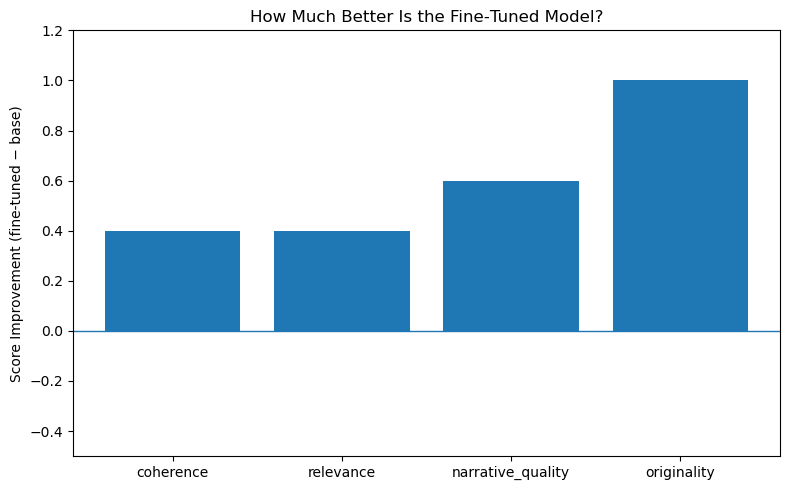

In [27]:
import matplotlib.pyplot as plt

summary = (scores_df.groupby("model", as_index=False)
                       .mean(numeric_only=True)
                       .round(2))

base_row       = summary[summary["model"] == "base"].iloc[0]
fine_row       = summary[summary["model"] == "fine_tuned"].iloc[0]
metrics        = ["coherence", "relevance", "narrative_quality", "originality"]
improvement    = fine_row[metrics].values - base_row[metrics].values

plt.figure(figsize=(8, 5))
plt.bar(metrics, improvement)
plt.axhline(0, linewidth=1)
plt.ylabel("Score Improvement (fine‑tuned − base)")
plt.title("How Much Better Is the Fine‑Tuned Model?")
plt.ylim(min(-0.5, improvement.min() - 0.2),
         max(0.5,  improvement.max() + 0.2))
plt.tight_layout()
plt.show()